# Random Acts of Pizza

This competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. Participants must create an algorithm capable of predicting which requests will garner a cheesy (but sincere!) act of kindness.

https://www.kaggle.com/c/random-acts-of-pizza

In [107]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import random
import datetime

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

##### Load the data

Data fields:

"giver_username_if_known": Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise).

"number_of_downvotes_of_request_at_retrieval": Number of downvotes at the time the request was collected.

"number_of_upvotes_of_request_at_retrieval": Number of upvotes at the time the request was collected.

"post_was_edited": Boolean indicating whether this post was edited (from Reddit).

"request_id": Identifier of the post on Reddit, e.g. "t3_w5491".

"request_number_of_comments_at_retrieval": Number of comments for the request at time of retrieval.

"request_text": Full text of the request.

"request_text_edit_aware": Edit aware version of "request_text". We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous".

"request_title": Title of the request.

"requester_account_age_in_days_at_request": Account age of requester in days at time of request.

"requester_account_age_in_days_at_retrieval": Account age of requester in days at time of retrieval.

"requester_days_since_first_post_on_raop_at_request": Number of days between requesters first post on RAOP and this request (zero if requester has never posted before on RAOP).

"requester_days_since_first_post_on_raop_at_retrieval": Number of days between requesters first post on RAOP and time of retrieval.

"requester_number_of_comments_at_request": Total number of comments on Reddit by requester at time of request.

"requester_number_of_comments_at_retrieval": Total number of comments on Reddit by requester at time of retrieval.

"requester_number_of_comments_in_raop_at_request": Total number of comments in RAOP by requester at time of request.

"requester_number_of_comments_in_raop_at_retrieval": Total number of comments in RAOP by requester at time of retrieval.

"requester_number_of_posts_at_request": Total number of posts on Reddit by requester at time of request.

"requester_number_of_posts_at_retrieval": Total number of posts on Reddit by requester at time of retrieval.

"requester_number_of_posts_on_raop_at_request": Total number of posts in RAOP by requester at time of request.

"requester_number_of_posts_on_raop_at_retrieval": Total number of posts in RAOP by requester at time of retrieval.

"requester_number_of_subreddits_at_request": The number of subreddits in which the author had already posted in at the time of request.

"requester_received_pizza": Boolean indicating the success of the request, i.e., whether the requester received pizza.

"requester_subreddits_at_request": The list of subreddits in which the author had already posted in at the time of request.

"requester_upvotes_minus_downvotes_at_request": Difference of total upvotes and total downvotes of requester at time of request.

"requester_upvotes_minus_downvotes_at_retrieval": Difference of total upvotes and total downvotes of requester at time of retrieval.

"requester_upvotes_plus_downvotes_at_request": Sum of total upvotes and total downvotes of requester at time of request.

"requester_upvotes_plus_downvotes_at_retrieval": Sum of total upvotes and total downvotes of requester at time of retrieval.

"requester_user_flair": Users on RAOP receive badges (Reddit calls them flairs) which is a small picture next to their username. In our data set the user flair is either None (neither given nor received pizza, N=4282), "shroom" (received pizza, but not given, N=1306), or "PIF" (pizza given after having received, N=83).

"requester_username": Reddit username of requester.

"unix_timestamp_of_request": Unix timestamp of request (supposedly in timezone of user, but in most cases it is equal to the UTC timestamp -- which is incorrect since most RAOP users are from the USA).

"unix_timestamp_of_request_utc": Unit timestamp of request in UTC.

In [55]:
# Put data in "Data" folder which is in the same location as this notebook
os.getcwd()
os.chdir('Data')
os.getcwd()
#os.chdir('C:\Users\zolotab\Desktop\w207-Machine-Learning-Final-Project-master\w207-Machine-Learning-Final-Project-master\Data')

'C:\\Users\\mpowers\\Documents\\Berkeley\\W207 Machine Learning\\Assignments\\Final Project\\Data'

In [56]:
# load data from json files to df
with open('train.json') as fin:
    trainjson = json.load(fin)

with open('test.json') as fin:
    testjson = json.load(fin)
    
df_train = pd.io.json.json_normalize(trainjson)
df_test = pd.io.json.json_normalize(testjson)

The outcome variable requester_received_pizza indicates if the user received pizza or not. The explanatory variables we are interested in using are free text fields that contain the title and text of the written request: request_title and request_text_edit_aware. We may also want to keep the unique id so our subset of data has a key: request_id.

In [4]:
df_train.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

In [5]:
df_test.columns

Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')

# The training and test datasets do not have the same number of features.  Most importantly, the test data does not have the "requester_received_pizza" output label!

# Remove Missing Values

In [6]:
print(len(df_train[df_train['request_text']==""]))
print(len(df_train[df_train['request_text_edit_aware']==""]))
print(df_train['request_text_edit_aware'].isnull().sum())

104
104
0


looks like there are some rows with missing text.  However there are no rows that are recognized as NaN.

In [7]:
df_train.ix[np.where(df_train['request_text_edit_aware']=="")].head()

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
41,N/A,2,11,False,t3_rtzx6,12,,,"(Request) Bowling Green, Ohio. My bank accoun...",249.293229,...,True,"[4chan, AdviceAnimals, AmISexy, Art, AskReddit...",3843,6993,6429,12127,shroom,bingbangbooom,1.333596e+09,1.333592e+09
125,N/A,3,5,False,t3_1d743u,3,,,[Request] I am hungry and would like to have s...,249.185787,...,False,[UniversityofReddit],1,6,1,18,None,sir_scotch,1.367036e+09,1.367033e+09
174,N/A,9,9,False,t3_18h7g0,1,,,[REQUEST] Kentucky USA i am so hungry. please ...,508.154676,...,False,"[LoLGaymers, Random_Acts_Of_Pizza, WTF, gaymer...",4,4,22,22,None,tyalah,1.360799e+09,1.360799e+09
250,N/A,0,4,False,t3_1n1ors,0,,,"[REQUEST] Belmont, MA. Broke and sick. Pizza w...",239.692940,...,False,"[AMA, Anxiety, AskMen, AskReddit, Assistance, ...",1415,1419,2631,2639,None,tOki_Sori,1.380077e+09,1.380049e+09
308,N/A,1,7,False,t3_1czbz2,0,,,"[request] London, Ontario. I just quit smoking...",162.118854,...,False,"[AdviceAnimals, AskReddit, Music, NewOrleans, ...",22,37,72,95,None,Juiceyp,1.366772e+09,1.366769e+09


In [7]:
np.where(df_train['request_text_edit_aware']=="")

(array([  41,  125,  174,  250,  308,  325,  340,  343,  409,  605,  735,
         751,  852,  858,  866,  886,  900,  916,  951, 1055, 1205, 1211,
        1228, 1248, 1272, 1281, 1375, 1379, 1402, 1416, 1456, 1484, 1505,
        1546, 1562, 1611, 1628, 1643, 1650, 1664, 1666, 1687, 1699, 1755,
        1870, 1922, 1932, 2018, 2052, 2077, 2215, 2230, 2232, 2310, 2368,
        2393, 2408, 2462, 2506, 2569, 2577, 2672, 2683, 2698, 2778, 2787,
        2800, 2819, 2826, 2860, 2869, 2889, 2912, 2936, 2956, 2966, 2971,
        2986, 2996, 3010, 3033, 3090, 3134, 3152, 3168, 3310, 3330, 3360,
        3421, 3430, 3467, 3510, 3589, 3610, 3627, 3717, 3735, 3749, 3767,
        3867, 3880, 3892, 4022, 4027], dtype=int64),)

In [8]:
df_train.ix[41].request_text

C:\Users\mpowers\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


''

In [10]:
# This removes the empty rows, however it screws up the vectorizer by creating "NaNs" elsewhere
# df_train = df_train.drop(df_train.index[np.where(df_train['request_text_edit_aware']=="")])

# Split data sets into train/dev/test

Since the test data does not indicate whether a pizza was revceived we split the trainer data to have a labeled test set.

In [57]:
# randomize and split data set into train test and dev using 60/20/20 split
random.seed(33)
shuffle = np.random.permutation(np.arange(df_train.shape[0]))
df_train_data, df_train_labels = df_train.ix[shuffle, :], df_train.ix[shuffle, 'requester_received_pizza']
#df_train_data, df_train_labels = df_train, df_train['requester_received_pizza']

# Set some variables to test, dev and training data
cutoff1 = int(df_train_labels.shape[0]*0.6)
cutoff2 = int(df_train_labels.shape[0]*0.8)
train_data, train_labels = df_train_data[:cutoff1], df_train_labels[:cutoff1]
dev_data, dev_labels = df_train_data[cutoff1:cutoff2], df_train_labels[cutoff1:cutoff2]
test_mini_data, test_mini_labels = df_train_data[cutoff2:], df_train_labels[cutoff2:]

print ('train data shape: ', train_data.shape)
print ('dev data shape:', dev_data.shape)
print ('test data shape:', test_mini_data.shape)

train data shape:  (2424, 32)
dev data shape: (808, 32)
test data shape: (808, 32)


C:\Users\mpowers\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


# EDA - are there any linear relationships between the numeric features and the outcome variable?

In [12]:
# Only look at the features that are available in the test data

np.intersect1d(df_train.columns, df_test.columns)

array(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request',
       'requester_username', 'unix_timestamp_of_request',
       'unix_timestamp_of_request_utc'], dtype=object)

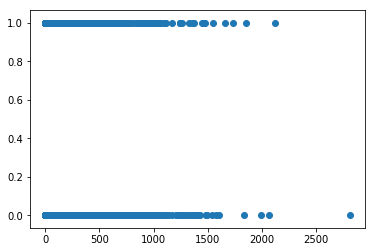

In [13]:
# sample scatter plot
fig = plt.figure()
ax = plt.gca()
ax.scatter(train_data['requester_account_age_in_days_at_request'], train_data['requester_received_pizza'])
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.show()

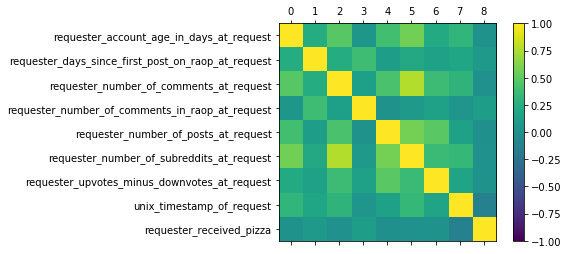

In [14]:
# Correlations
numeric_features = ['requester_account_age_in_days_at_request', 
                                  'requester_days_since_first_post_on_raop_at_request', 
                                 'requester_number_of_comments_at_request', 
                                  'requester_number_of_comments_in_raop_at_request',
                                 'requester_number_of_posts_at_request', 
                                  'requester_number_of_subreddits_at_request', 
                                  'requester_upvotes_minus_downvotes_at_request', 
                                  'unix_timestamp_of_request', 
                                  'requester_received_pizza' ]
correlations = train_data[numeric_features].corr()

# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
#ax.set_xticklabels(numeric_features)
ax.set_yticklabels(numeric_features)
plt.show()

As expected there are high correlations between number of posts and age of account as well as number of subreddits, however low correlation with the outcome variable 'requester_received_pizza'.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000011A76D30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001620C2B0>]], dtype=object)

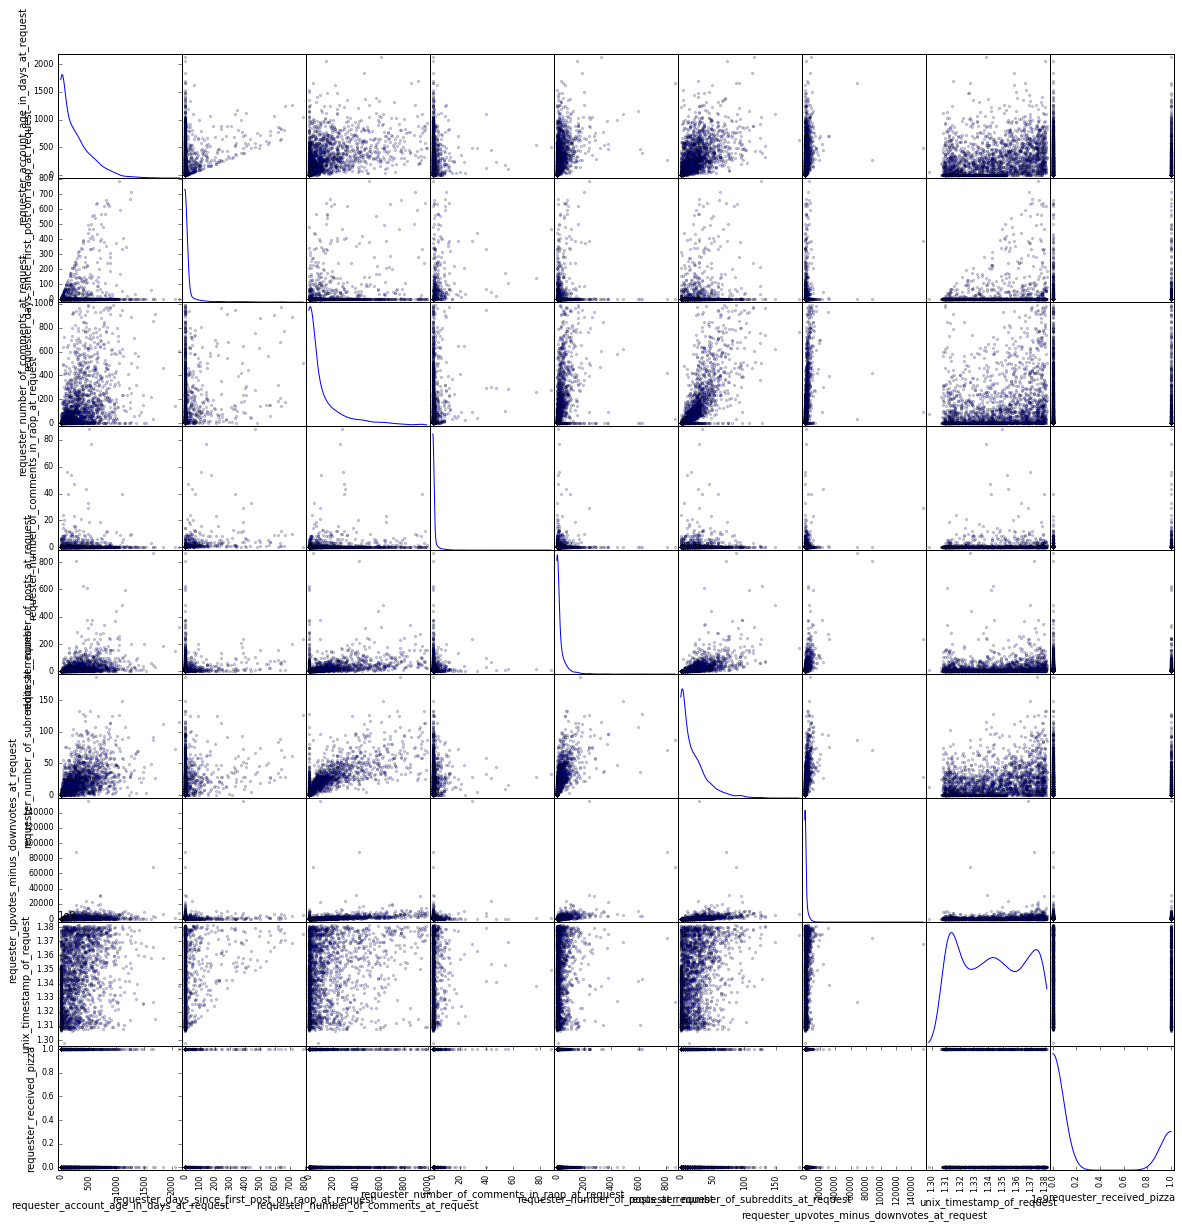

In [15]:
# Scatter plot matrix
from pandas import scatter_matrix

scatter_matrix(train_data[numeric_features], alpha=0.2, figsize=(20, 20), diagonal='kde')

# Modeling using Naive Count Vectorizer

# Vectorizing the text features

In [58]:
vectorizer = CountVectorizer()
train_data_nlp = vectorizer.fit_transform(train_data['request_text_edit_aware'])
dev_data_nlp = vectorizer.transform(dev_data['request_text_edit_aware'])
test_mini_data_nlp = vectorizer.transform(test_mini_data['request_text_edit_aware'])

In [59]:
print("Size of the vocabulary:")
print(train_data_nlp.shape[1])

Size of the vocabulary:
9389


# KNN Model

In [60]:
k_values = {"n_neighbors": list(range(1,10))}
knn_gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=k_values)
knn_gs.fit(dev_data_nlp, dev_labels)
print (knn_gs.best_params_)

{'n_neighbors': 8}


In [61]:
knn_clf_best = KNeighborsClassifier(n_neighbors=knn_gs.best_params_['n_neighbors'])
knn_clf_best.fit(train_data_nlp, train_labels)
knn_clf_best_predicted = knn_clf_best.predict(test_mini_data_nlp)

print ("KNN accuracy:")
print(accuracy_score(knn_clf_best_predicted, test_mini_labels) * 100)

KNN accuracy:
76.11386138613861


In [62]:
# print confusion matrix to identify mistakes
print ("Confusion matrix:")
print (confusion_matrix(test_mini_labels, knn_clf_best_predicted))

Confusion matrix:
[[611   4]
 [189   4]]


# Multinomial Model

In [63]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp, dev_labels)
print (multi_gs.best_params_)

{'alpha': 5}


In [64]:
multi_clf_best = MultinomialNB(alpha=multi_gs.best_params_['alpha'])
multi_clf_best.fit(train_data_nlp, train_labels)
multi_clf_best_predicted = multi_clf_best.predict(test_mini_data_nlp)

print ("Multinomial accuracy:")
print(accuracy_score(multi_clf_best_predicted, test_mini_labels) * 100)

Multinomial accuracy:
75.99009900990099


In [65]:
# print confusion matrix to identify mistakes
print ("Confusion matrix:")
print (confusion_matrix(test_mini_labels, multi_clf_best_predicted))

Confusion matrix:
[[614   1]
 [193   0]]


# Logistic Model

In [66]:
# Logisitc modeling
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp, dev_labels)
print (log_gs.best_params_)

{'C': 0.001}


In [67]:
log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data_nlp, train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data_nlp)

print ("Logistic accuracy:")
print(accuracy_score(log_clf_best_predicted, test_mini_labels) * 100)

Logistic accuracy:
76.11386138613861


In [68]:
# print confusion matrix to identify mistakes
print ("Confusion matrix:")
print (confusion_matrix(test_mini_labels, log_clf_best_predicted))

Confusion matrix:
[[615   0]
 [193   0]]


# Advanced Count Vectorizer

code from the Kaggle kernel

In [27]:
# # ***** Run Once *****
# # Downloading corpus of stopwords and other functions

# nltk.download()

In [69]:
# Removing stopwords and punctuations

from string import punctuation
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize


stopwords_en = set(stopwords.words('english'))

# Stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
# Combine the stopwords. Its a lot longer so I'm not printing it out...
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

In [70]:
# Removing stemming and lemmatization

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

# tagging part of speech so that lemmatization can be done
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

In [90]:
# updated preprocessor

def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    
    # Convert all text to lowercase
    text = text.lower()
    
    # Replace sequences of numbers with a single token
    text = re.sub(r'\d+','numseq',text)
    
    # Remove non letter characters
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]



In [91]:
vectorizer2 = CountVectorizer(analyzer=preprocess_text)
train_data_nlp2 = vectorizer2.fit_transform(train_data['request_text_edit_aware'])
dev_data_nlp2 = vectorizer2.transform(dev_data['request_text_edit_aware'])
test_mini_data_nlp2 = vectorizer2.transform(test_mini_data['request_text_edit_aware'])

In [92]:
print("Size of the vocabulary:")
print(train_data_nlp2.shape[1])

Size of the vocabulary:
7117


In [93]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp2, dev_labels)
print (multi_gs.best_params_)

{'alpha': 5}


In [94]:
multi_clf_best = MultinomialNB(alpha=multi_gs.best_params_['alpha'])
multi_clf_best.fit(train_data_nlp2, train_labels)
multi_clf_best_predicted = multi_clf_best.predict(test_mini_data_nlp2)

print ("Multinomial accuracy:")
print(accuracy_score(multi_clf_best_predicted, test_mini_labels) * 100)

Multinomial accuracy:
75.99009900990099


In [95]:
# Logisitc modeling
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp2, dev_labels)
print (log_gs.best_params_)

{'C': 0.001}


In [96]:
log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data_nlp2, train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data_nlp2)

print ("Logistic accuracy:")
print(accuracy_score(log_clf_best_predicted, test_mini_labels) * 100)

Logistic accuracy:
76.11386138613861


# Advanced Count Vectorizer (Request Text and Title)

In [109]:
# Create field that concatenates the request text and title in case the title contains more predictive power
train_data['request_title_and_text'] = train_data['request_title'] + ' ' + train_data['request_text_edit_aware']
dev_data['request_title_and_text'] = dev_data['request_title'] + ' ' + dev_data['request_text_edit_aware']
test_mini_data['request_title_and_text'] = test_mini_data['request_title'] + ' ' + test_mini_data['request_text_edit_aware']

In [99]:
vectorizer2 = CountVectorizer(analyzer=preprocess_text)
train_data_nlp2 = vectorizer2.fit_transform(train_data['request_title_and_text'])
dev_data_nlp2 = vectorizer2.transform(dev_data['request_title_and_text'])
test_mini_data_nlp2 = vectorizer2.transform(test_mini_data['request_title_and_text'])

In [100]:
print("Size of the vocabulary:")
print(train_data_nlp2.shape[1])

Size of the vocabulary:
7768


In [101]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp2, dev_labels)
print (multi_gs.best_params_)

{'alpha': 5}


In [102]:
multi_clf_best = MultinomialNB(alpha=multi_gs.best_params_['alpha'])
multi_clf_best.fit(train_data_nlp2, train_labels)
multi_clf_best_predicted = multi_clf_best.predict(test_mini_data_nlp2)

print ("Multinomial accuracy:")
print(accuracy_score(multi_clf_best_predicted, test_mini_labels) * 100)

Multinomial accuracy:
75.99009900990099


In [103]:
# Logisitc modeling
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp2, dev_labels)
print (log_gs.best_params_)

{'C': 0.03}


In [105]:
log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data_nlp2, train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data_nlp2)

print ("Logistic accuracy:")
print(accuracy_score(log_clf_best_predicted, test_mini_labels) * 100)

Logistic accuracy:
74.75247524752476


# Analyze Numeric Features - Random Forests

In [118]:
# Feature engineering ideas:

# 1. length of request - number of characters
train_data['request_len'] = train_data['request_text_edit_aware'].str.len()
dev_data['request_len'] = dev_data['request_text_edit_aware'].str.len()
test_mini_data['request_len'] = test_mini_data['request_text_edit_aware'].str.len()

# 2. Month of request (rather than timestamp)
train_data['request_month'] = train_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).month)
dev_data['request_month'] = dev_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).month)
test_mini_data['request_month'] = test_mini_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).month)


In [ ]:
numeric_features = ['requester_account_age_in_days_at_request', 
                                  'requester_days_since_first_post_on_raop_at_request', 
                                 'requester_number_of_comments_at_request', 
                                  'requester_number_of_comments_in_raop_at_request',
                                 'requester_number_of_posts_at_request', 
                                  'requester_number_of_subreddits_at_request', 
                                  'requester_upvotes_minus_downvotes_at_request', 
                                    'request_len',
                                    'request_month'
                                  'requester_received_pizza' ]